In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
45 packages can be upgraded. Run 'apt list --upgradable' to see them.
tar: spark-3.2.1-bin-hadoop3.2.tgz: Cannot open: No such file or directory
tar: Error is not recov

In [ ]:
import pyspark
import pyspark.sql.functions as F
import numpy as np
from pyspark.sql import SparkSession
import numpy as np
from datetime import datetime, timedelta
from pyspark.sql.window import Window
import numpy as np
import math
import pandas as pd
import subprocess
from google.colab import drive
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

In [ ]:
################################
appName = 'abd18'
spark = SparkSession.builder\
                    .appName(appName) \
                    .getOrCreate()
sc = spark.sparkContext

In [ ]:
spark

In [ ]:
# Load data
combined_data = spark.read.csv("/content/aal.csv", header=True, inferSchema=True)
# Order by date
combined_data = combined_data.orderBy("date")
combined_data.show()
combined_data.tail(7)

+----+------+----------+------------------+------------------+------------------+------------------+------------------+---------+------+
| cik|ticker|      date|              open|              high|               low|             close|          adjclose|   volume|    rn|
+----+------+----------+------------------+------------------+------------------+------------------+------------------+---------+------+
|6201|   AAL|2018-01-02| 52.33000183105469|53.099998474121094|51.900001525878906|  52.9900016784668|51.647560119628906|4084700.0|113675|
|6201|   AAL|2018-01-03| 52.86000061035156| 52.86000061035156|52.060001373291016| 52.34000015258789| 51.01402282714844|5074900.0|113674|
|6201|   AAL|2018-01-04| 52.47999954223633|54.400001525878906| 52.27000045776367| 52.66999816894531| 51.33566665649414|3557100.0|113673|
|6201|   AAL|2018-01-05|52.779998779296875| 52.84000015258789| 52.43000030517578|52.650001525878906|  51.3161735534668|2967800.0|113672|
|6201|   AAL|2018-01-08|52.59999847412109

[Row(cik=6201, ticker='AAL', date=datetime.date(2024, 4, 15), open=13.279999732971191, high=13.470000267028809, low=12.899999618530273, close=12.9399995803833, adjclose=12.9399995803833, volume=27451700.0, rn=5701),
 Row(cik=6201, ticker='AAL', date=datetime.date(2024, 4, 16), open=12.949999809265137, high=13.140000343322754, low=12.720000267028809, close=13.029999732971191, adjclose=13.029999732971191, volume=26477200.0, rn=5700),
 Row(cik=6201, ticker='AAL', date=datetime.date(2024, 4, 17), open=13.449999809265137, high=13.970000267028809, low=13.380000114440918, close=13.890000343322754, adjclose=13.890000343322754, volume=52414800.0, rn=5699),
 Row(cik=6201, ticker='AAL', date=datetime.date(2024, 4, 18), open=14.039999961853027, high=14.34000015258789, low=13.960000038146973, close=14.020000457763672, adjclose=14.020000457763672, volume=34966400.0, rn=5698),
 Row(cik=6201, ticker='AAL', date=datetime.date(2024, 4, 19), open=13.880000114440918, high=14.279999732971191, low=13.859999

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import year, month, dayofmonth


# Extract year, month, and day from the date column
data_with_features = combined_data.withColumn("year", year("date")) \
                                  .withColumn("month", month("date")) \
                                  .withColumn("day", dayofmonth("date"))
# Order again
data_with_features = data_with_features.orderBy("date")

# Split data into train and test 80/20
# It can't be random split because it is a Time Series model
split_index = int(0.8 * data_with_features.count())
train_data = data_with_features.limit(split_index)
test_data = data_with_features.subtract(train_data)

# Define the features
feature_columns = ['year', 'month', 'day']
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define the RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features", labelCol="close")  # Assuming you want to predict 'close' based on 'date'

# Create a pipeline
pipeline = Pipeline(stages=[vector_assembler, rf])

# Define parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# Define evaluator
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")

# Create CrossValidator
cross_val = CrossValidator(estimator=pipeline,
                           estimatorParamMaps=param_grid,
                           evaluator=evaluator,
                           numFolds=3)

# Fit the model
cv_model = cross_val.fit(train_data)

# Get best model
best_model = cv_model.bestModel

# Make predictions on the test set
predictions = best_model.transform(test_data)

# Evaluate the model on test data
rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data =", rmse)

Root Mean Squared Error (RMSE) on test data = 2.6792367366282606


In [ ]:
# Get the params and RMSE for the different models
params = [{p.name: v for p, v in m.items()} for m in cv_model.getEstimatorParamMaps()]
import pandas as pd

pd.DataFrame.from_dict([
    {cv_model.getEvaluator().getMetricName(): metric, **ps}
    for ps, metric in zip(params, cv_model.avgMetrics)
])

,rmse,numTrees,maxDepth
0,3.636217,10,5
1,2.454477,10,10
2,2.407075,10,15
3,4.205857,20,5
4,2.898748,20,10
5,2.842003,20,15
6,4.038197,30,5
7,2.830784,30,10
8,2.782990,30,15


In [ ]:
import time

# New split without the last 7 days
split_index = int(data_with_features.count() - 7)
train_data = data_with_features.limit(split_index)
test_data = data_with_features.subtract(train_data)

# Test length should be the 7 days
print("Test data length:", test_data.count())

# Define the features column
feature_columns = ['year', 'month', 'day']
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define the RandomForestRegressor with the best parameters obtained from cross-validation
best_rf = RandomForestRegressor(featuresCol="features", labelCol="close", maxDepth=15, numTrees=10)

# Create a pipeline
pipeline = Pipeline(stages=[vector_assembler, best_rf])

# Fit the model on the entire dataset except the last 7 days
start_time = time.time()
model = pipeline.fit(train_data)
end_time = time.time()
print("Training time: {:.2f} seconds".format(end_time - start_time))

# Make predictions on the entire dataset
predictions = model.transform(test_data)

# Define evaluator
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="r2")

# Evaluate the model on test data
rmse = evaluator.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("Model results for last 7 days")
print("Root Mean Squared Error (RMSE) on test data =", rmse)
print("Mean Absolute Error (MAE) on test data =", mae)
print("R-squared (R2) on test data =", r2)

Test data length: 7
Training time: 2.45 seconds
Model results for last 7 days
Root Mean Squared Error (RMSE) on test data = 0.5983982448957238
Mean Absolute Error (MAE) on test data = 0.43950173316311464
R-squared (R2) on test data = -0.0945823866902531


In [ ]:
predictions.show()

+----+------+----------+------------------+------------------+------------------+------------------+------------------+-----------+----+----+-----+---+-----------------+------------------+
| cik|ticker|      date|              open|              high|               low|             close|          adjclose|     volume|  rn|year|month|day|         features|        prediction|
+----+------+----------+------------------+------------------+------------------+------------------+------------------+-----------+----+----+-----+---+-----------------+------------------+
|6201|   AAL|2024-04-15|13.279999732971191|13.470000267028809|12.899999618530273|  12.9399995803833|  12.9399995803833|  2.74517E7|5701|2024|    4| 15|[2024.0,4.0,15.0]|14.033287492520179|
|6201|   AAL|2024-04-16|12.949999809265137|13.140000343322754|12.720000267028809|13.029999732971191|13.029999732971191|  2.64772E7|5700|2024|    4| 16|[2024.0,4.0,16.0]|14.058620833482905|
|6201|   AAL|2024-04-17|13.449999809265137|13.970000267

In [ ]:
test_data = test_data.orderBy("date")
test_data.show()

+----+------+----------+------------------+------------------+------------------+------------------+------------------+-----------+----+----+-----+---+
| cik|ticker|      date|              open|              high|               low|             close|          adjclose|     volume|  rn|year|month|day|
+----+------+----------+------------------+------------------+------------------+------------------+------------------+-----------+----+----+-----+---+
|6201|   AAL|2024-04-15|13.279999732971191|13.470000267028809|12.899999618530273|  12.9399995803833|  12.9399995803833|  2.74517E7|5701|2024|    4| 15|
|6201|   AAL|2024-04-16|12.949999809265137|13.140000343322754|12.720000267028809|13.029999732971191|13.029999732971191|  2.64772E7|5700|2024|    4| 16|
|6201|   AAL|2024-04-17|13.449999809265137|13.970000267028809|13.380000114440918|13.890000343322754|13.890000343322754|  5.24148E7|5699|2024|    4| 17|
|6201|   AAL|2024-04-18|14.039999961853027| 14.34000015258789|13.960000038146973|14.0200

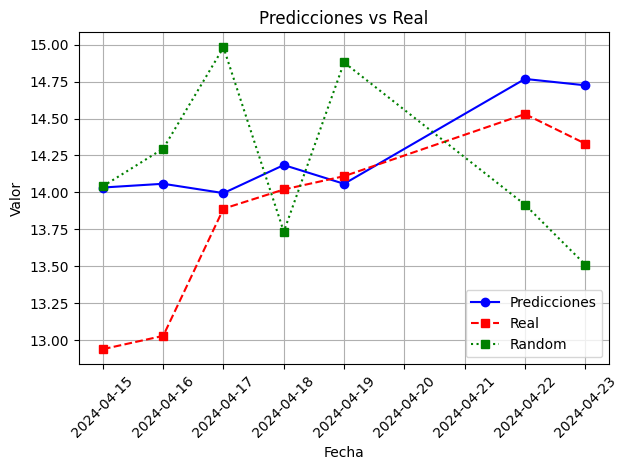

In [64]:
import matplotlib.pyplot as plt
import random

predictions = predictions.orderBy("date")

# Collecting data from DataFrame columns as lists
dates = predictions.select("date").rdd.flatMap(lambda x: x).collect()
predictions_values = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
real_values = predictions.select("close").rdd.flatMap(lambda x: x).collect()
valores_random = [random.uniform(13, 15) for _ in range(7)]

# Plotting the data
plt.plot(dates, predictions_values, label='Predicciones', linestyle='-', marker='o', color='b')
plt.plot(dates, real_values, label='Real', linestyle='--', marker='s', color='r')
plt.plot(dates, valores_random, label='Random', linestyle=':', marker='s', color='g')

# Labels and legend
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Predicciones vs Real')
plt.legend()

# Displaying the plot
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if necessary
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()
